# Evaluation Metric - Track A, Subtask 3 (DimASQP)

This notebook evaluates the **Dimensional Aspect Sentiment Quad Prediction (DimASQP)** task using the **continuous F1 (cF1)** metric as defined in the DimABSA2026 shared task.

## Task Description
**Subtask 3: DimASQP** - Extract all quadruplets **(A, C, O, VA)** where:
- **A**: Aspect term
- **C**: Aspect category
- **O**: Opinion term
- **VA**: Valence-Arousal score (V#A format, values in [1.00, 9.00])

## Evaluation Metric: Continuous F1 (cF1)

The evaluation uses **continuous True Positive (cTP)** which extends the categorical TP by incorporating a penalty based on VA prediction error:

$$cTP^{(t)} = \begin{cases} 1 - \text{dist}(VA_p^{(t)}, VA_g^{(t)}), & t \in P_{cat} \\ 0, & \text{otherwise} \end{cases}$$

where the distance function is:

$$\text{dist}(VA_p, VA_g) = \frac{\sqrt{(V_p - V_g)^2 + (A_p - A_g)^2}}{D_{max}}$$

with $D_{max} = \sqrt{128}$ (maximum Euclidean distance in VA space [1,9]).

**Continuous Recall:**
$$cRecall = \frac{TP_{cat} - \sum_{t \in P_{cat}} \text{dist}(VA_p^{(t)}, VA_g^{(t)})}{TP_{cat} + FN_{cat}}$$

**Continuous Precision:**
$$cPrecision = \frac{TP_{cat} - \sum_{t \in P_{cat}} \text{dist}(VA_p^{(t)}, VA_g^{(t)})}{TP_{cat} + FP_{cat}}$$

**Continuous F1:**
$$cF1 = \frac{2 \times cRecall \times cPrecision}{cRecall + cPrecision}$$

In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scipy -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import necessary libraries
import json
import math
import os
from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data Files

Load the ground truth (gold) and prediction files.

In [2]:
# File paths
gold_file_path = r"task-dataset\track_a\subtask_3\eng\eng_restaurant_train_alltasks.jsonl"
pred_file_path = r"pred_eng_restaurant_test_split_subtask3.jsonl"

# Check if files exist
if not os.path.exists(gold_file_path):
    print(f"Error: Gold file not found at '{gold_file_path}'")
else:
    print(f"Gold file found: {gold_file_path}")

if not os.path.exists(pred_file_path):
    print(f"Error: Prediction file not found at '{pred_file_path}'")
else:
    print(f"Prediction file found: {pred_file_path}")

Gold file found: task-dataset\track_a\subtask_3\eng\eng_restaurant_train_alltasks.jsonl
Prediction file found: pred_eng_restaurant_test_split_subtask3.jsonl


In [3]:
def read_jsonl_file(file_path: str) -> List[Dict]:
    """
    Read a JSONL file and return a list of dictionaries.
    
    Args:
        file_path: Path to the JSONL file
        
    Returns:
        List of dictionaries containing the data
    """
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if not line:  # Skip empty lines
                    continue
                try:
                    json_data = json.loads(line)
                    data.append(json_data)
                except json.JSONDecodeError as e:
                    print(f"Warning: JSON parsing error at line {line_num}: {e}")
                    continue
    except Exception as e:
        print(f"Error reading file '{file_path}': {e}")
        return []
    
    return data

# Load the data
print("Loading data files...\n")
gold_data = read_jsonl_file(gold_file_path)
pred_data = read_jsonl_file(pred_file_path)

print(f"Loaded {len(gold_data)} gold entries")
print(f"Loaded {len(pred_data)} prediction entries")

Loading data files...

Loaded 2284 gold entries
Loaded 344 prediction entries


## 2. Data Exploration

Let's explore the structure of our data to understand what we're working with.

In [4]:
# Display sample entries from gold data
print("="*80)
print("GOLD DATA - Sample Entry")
print("="*80)
if gold_data:
    sample_gold = gold_data[0]
    print(f"ID: {sample_gold['ID']}")
    print(f"Text: {sample_gold['Text']}")
    print(f"\nQuadruplets ({len(sample_gold.get('Quadruplet', []))}):")
    for i, quad in enumerate(sample_gold.get('Quadruplet', []), 1):
        print(f"  {i}. Aspect: '{quad.get('Aspect')}'")
        print(f"     Category: '{quad.get('Category')}'")
        print(f"     Opinion: '{quad.get('Opinion')}'")
        print(f"     VA: {quad.get('VA')}")
        print()

print("\n" + "="*80)
print("PREDICTION DATA - Sample Entry")
print("="*80)
if pred_data:
    sample_pred = pred_data[0]
    print(f"ID: {sample_pred['ID']}")
    print(f"Text: {sample_pred.get('Text', 'N/A')}")
    print(f"\nQuadruplets ({len(sample_pred.get('Quadruplet', []))}):")
    for i, quad in enumerate(sample_pred.get('Quadruplet', []), 1):
        print(f"  {i}. Aspect: '{quad.get('Aspect')}'")
        print(f"     Category: '{quad.get('Category')}'")
        print(f"     Opinion: '{quad.get('Opinion')}'")
        print(f"     VA: {quad.get('VA')}")
        print()

GOLD DATA - Sample Entry
ID: rest16_quad_dev_1
Text: ca n ' t wait wait for my next visit .

Quadruplets (1):
  1. Aspect: 'NULL'
     Category: 'RESTAURANT#GENERAL'
     Opinion: 'NULL'
     VA: 6.75#6.38


PREDICTION DATA - Sample Entry
ID: rest16_quad_train_413
Text: N/A

Quadruplets (3):
  1. Aspect: 'menu'
     Category: 'FOOD#GENERAL'
     Opinion: 'limited'
     VA: 6.09#6.86

  2. Aspect: 'preparation'
     Category: 'FOOD#QUALITY'
     Opinion: 'done to perfection'
     VA: 7.82#7.81

  3. Aspect: 'NULL'
     Category: 'FOOD#MISCELLANEOUS'
     Opinion: 'NULL'
     VA: 5.10#5.35



## 3. Data Preprocessing

Normalize the data for evaluation (convert to lowercase, organize by ID).

**Important Note on Evaluation Scope:**

The evaluation is performed ONLY on the IDs present in the prediction file (test set). This is the correct approach because:

1. The gold file contains the entire training dataset (2,284 reviews)
2. The prediction file contains only the test set samples (344 reviews)
3. We should evaluate performance only on the test set, not on all gold data

This ensures that:
- False Negatives (FN) are counted only for gold quadruplets in the test set that were not predicted
- The metrics accurately reflect model performance on the actual test set
- We avoid artificially inflating FN by including training samples not in the prediction file

In [5]:
def normalize_quadruplet(quad: Dict) -> Dict:
    """
    Normalize a quadruplet by converting text fields to lowercase.
    
    Args:
        quad: Dictionary containing Aspect, Category, Opinion, VA
        
    Returns:
        Normalized quadruplet dictionary
    """
    return {
        'Aspect': quad.get('Aspect', '').lower(),
        'Category': quad.get('Category', '').lower(),
        'Opinion': quad.get('Opinion', '').lower(),
        'VA': quad.get('VA', '0.00#0.00')
    }

def preprocess_data(data: List[Dict]) -> Dict[str, List[Dict]]:
    """
    Preprocess data by normalizing and indexing by ID.
    
    Args:
        data: List of data entries
        
    Returns:
        Dictionary mapping ID to list of normalized quadruplets
    """
    processed = {}
    for entry in data:
        entry_id = entry.get('ID')
        quadruplets = entry.get('Quadruplet', [])
        normalized_quads = [normalize_quadruplet(q) for q in quadruplets]
        processed[entry_id] = normalized_quads
    return processed

# Preprocess both gold and prediction data
gold_dict = preprocess_data(gold_data)
pred_dict = preprocess_data(pred_data)

print(f"✓ Preprocessed {len(gold_dict)} total gold entries")
print(f"✓ Preprocessed {len(pred_dict)} prediction entries (test set)")

# Check for ID mismatches
gold_ids = set(gold_dict.keys())
pred_ids = set(pred_dict.keys())
missing_in_gold = pred_ids - gold_ids
common_ids = pred_ids & gold_ids

print(f"\n📊 Evaluation Scope:")
print(f"   IDs in predictions (test set): {len(pred_ids)}")
print(f"   IDs found in gold data: {len(common_ids)}")
if missing_in_gold:
    print(f"   ⚠ Warning: {len(missing_in_gold)} prediction IDs not found in gold data")
    
# Count quadruplets for evaluation scope
total_gold_quads_for_test = sum(len(gold_dict.get(id_, [])) for id_ in pred_ids)
total_pred_quads = sum(len(pred_dict[id_]) for id_ in pred_ids)

print(f"\n📋 Quadruplet Statistics (Test Set Only):")
print(f"   Total gold quadruplets to evaluate: {total_gold_quads_for_test}")
print(f"   Total predicted quadruplets: {total_pred_quads}")

✓ Preprocessed 2284 total gold entries
✓ Preprocessed 344 prediction entries (test set)

📊 Evaluation Scope:
   IDs in predictions (test set): 344
   IDs found in gold data: 344

📋 Quadruplet Statistics (Test Set Only):
   Total gold quadruplets to evaluate: 551
   Total predicted quadruplets: 563


## 4. Implement Evaluation Metrics

Implementation of the continuous F1 (cF1) metric as defined in the task description.

In [6]:
def parse_va(va_string: str) -> Tuple[float, float]:
    """
    Parse VA string in format 'V#A' and return valence and arousal as floats.
    
    Args:
        va_string: String in format 'V#A' (e.g., '7.50#6.75')
        
    Returns:
        Tuple of (valence, arousal)
    """
    try:
        v_str, a_str = va_string.split('#')
        return float(v_str), float(a_str)
    except (ValueError, AttributeError) as e:
        print(f"⚠ Warning: Failed to parse VA string '{va_string}': {e}")
        return 0.0, 0.0

def calculate_va_distance(va_pred: str, va_gold: str) -> float:
    """
    Calculate normalized Euclidean distance between predicted and gold VA scores.
    
    Args:
        va_pred: Predicted VA string (format 'V#A')
        va_gold: Gold VA string (format 'V#A')
        
    Returns:
        Normalized distance in [0, 1]
    """
    v_pred, a_pred = parse_va(va_pred)
    v_gold, a_gold = parse_va(va_gold)
    
    # Calculate Euclidean distance
    euclidean_dist = math.sqrt((v_pred - v_gold)**2 + (a_pred - a_gold)**2)
    
    # Normalize by maximum possible distance in [1,9] x [1,9] space
    D_max = math.sqrt(128)  # sqrt(8^2 + 8^2)
    
    normalized_dist = euclidean_dist / D_max
    return normalized_dist

def quadruplet_to_tuple(quad: Dict) -> Tuple[str, str, str]:
    """
    Convert quadruplet to tuple of categorical fields (Aspect, Category, Opinion).
    
    Args:
        quad: Quadruplet dictionary
        
    Returns:
        Tuple of (Aspect, Category, Opinion)
    """
    return (
        quad.get('Aspect', ''),
        quad.get('Category', ''),
        quad.get('Opinion', '')
    )

def is_valid_va(va_string: str) -> bool:
    """
    Check if VA values are within valid range [1.0, 9.0].
    
    Args:
        va_string: VA string in format 'V#A'
        
    Returns:
        True if valid, False otherwise
    """
    v, a = parse_va(va_string)
    return 1.0 <= v <= 9.0 and 1.0 <= a <= 9.0

print("✓ Utility functions defined successfully!")

✓ Utility functions defined successfully!


In [7]:
def evaluate_subtask3(gold_dict: Dict[str, List[Dict]], 
                      pred_dict: Dict[str, List[Dict]]) -> Dict:
    """
    Evaluate Subtask 3 (DimASQP) using continuous F1 metric.
    
    Args:
        gold_dict: Dictionary mapping ID to gold quadruplets
        pred_dict: Dictionary mapping ID to predicted quadruplets
        
    Returns:
        Dictionary containing evaluation metrics
    """
    # Initialize counters
    cTP_total = 0.0  # Continuous True Positive
    TP_cat = 0       # Categorical True Positive (exact match for A, C, O)
    FP_cat = 0       # False Positive
    FN_cat = 0       # False Negative
    
    # Track warnings
    invalid_va_count = 0
    duplicate_pred_count = 0
    
    # Store detailed results for analysis
    detailed_results = []
    
    # IMPORTANT: Only consider IDs that are in the prediction file (test set)
    # This is the correct approach as we only evaluate on the test samples
    all_ids = set(pred_dict.keys())
    
    for entry_id in all_ids:
        gold_quads = gold_dict.get(entry_id, [])
        pred_quads = pred_dict.get(entry_id, [])
        
        matched_pred_indices = set()  # Track which predictions have been matched
        
        # For each gold quadruplet
        for gold_quad in gold_quads:
            gold_key = quadruplet_to_tuple(gold_quad)
            
            # Find all matching predictions for this gold quadruplet
            matching_predictions = []
            
            for pred_idx, pred_quad in enumerate(pred_quads):
                pred_key = quadruplet_to_tuple(pred_quad)
                
                # Check if categorical fields match (A, C, O)
                if gold_key == pred_key:
                    # Validate VA range
                    if not is_valid_va(pred_quad['VA']):
                        invalid_va_count += 1
                        matching_predictions.append((pred_idx, 0.0))  # cTP = 0 for invalid VA
                    else:
                        # Calculate cTP score
                        va_distance = calculate_va_distance(pred_quad['VA'], gold_quad['VA'])
                        cTP_score = max(0.0, 1.0 - va_distance)
                        matching_predictions.append((pred_idx, cTP_score))
            
            # Handle matching results
            if len(matching_predictions) > 1:
                # Duplicate predictions detected
                duplicate_pred_count += 1
                FN_cat += 1
                cTP_total += 0
            elif len(matching_predictions) == 1:
                # Exactly one match found
                pred_idx, cTP_score = matching_predictions[0]
                matched_pred_indices.add(pred_idx)
                TP_cat += 1
                cTP_total += cTP_score
                
                # Store detailed result
                detailed_results.append({
                    'ID': entry_id,
                    'Gold': gold_quad,
                    'Pred': pred_quads[pred_idx],
                    'cTP_score': cTP_score,
                    'VA_distance': 1 - cTP_score
                })
            else:
                # No match found
                FN_cat += 1
        
        # Count false positives (predictions with no gold match)
        FP_cat += len(pred_quads) - len(matched_pred_indices)
    
    # Calculate metrics
    cPrecision = cTP_total / (TP_cat + FP_cat) if (TP_cat + FP_cat) > 0 else 0.0
    cRecall = cTP_total / (TP_cat + FN_cat) if (TP_cat + FN_cat) > 0 else 0.0
    cF1 = 2 * cPrecision * cRecall / (cPrecision + cRecall) if (cPrecision + cRecall) > 0 else 0.0
    
    # Also calculate standard F1 (without VA penalty)
    standard_precision = TP_cat / (TP_cat + FP_cat) if (TP_cat + FP_cat) > 0 else 0.0
    standard_recall = TP_cat / (TP_cat + FN_cat) if (TP_cat + FN_cat) > 0 else 0.0
    standard_f1 = 2 * standard_precision * standard_recall / (standard_precision + standard_recall) if (standard_precision + standard_recall) > 0 else 0.0
    
    return {
        'TP_cat': TP_cat,
        'cTP_total': cTP_total,
        'FP_cat': FP_cat,
        'FN_cat': FN_cat,
        'cPrecision': cPrecision,
        'cRecall': cRecall,
        'cF1': cF1,
        'standard_precision': standard_precision,
        'standard_recall': standard_recall,
        'standard_f1': standard_f1,
        'invalid_va_count': invalid_va_count,
        'duplicate_pred_count': duplicate_pred_count,
        'detailed_results': detailed_results
    }

print("✓ Evaluation function defined successfully!")

✓ Evaluation function defined successfully!


## 5. Run Evaluation

Execute the evaluation and display comprehensive results.

In [8]:
# Run the evaluation
print("Running evaluation...\n")
results = evaluate_subtask3(gold_dict, pred_dict)

# Display results
print("="*80)
print("EVALUATION RESULTS - Track A, Subtask 3 (DimASQP)")
print("="*80)
print()

print("CATEGORICAL MATCHING (Aspect, Category, Opinion):")
print(f"   True Positives (TP_cat):  {results['TP_cat']}")
print(f"   False Positives (FP_cat): {results['FP_cat']}")
print(f"   False Negatives (FN_cat): {results['FN_cat']}")
print()

print("CONTINUOUS METRICS (with VA penalty):")
print(f"   Continuous TP (cTP):      {results['cTP_total']:.4f}")
print(f"   Continuous Precision:     {results['cPrecision']:.4f}")
print(f"   Continuous Recall:        {results['cRecall']:.4f}")
print(f"   Continuous F1 (cF1):      {results['cF1']:.4f}")
print()

print("STANDARD METRICS (without VA penalty):")
print(f"   Standard Precision:       {results['standard_precision']:.4f}")
print(f"   Standard Recall:          {results['standard_recall']:.4f}")
print(f"   Standard F1:              {results['standard_f1']:.4f}")
print()

if results['invalid_va_count'] > 0:
    print(f"Warning: {results['invalid_va_count']} predictions with invalid VA values (outside [1,9] range)")
if results['duplicate_pred_count'] > 0:
    print(f"Warning: {results['duplicate_pred_count']} gold quadruplets with duplicate predictions")

print()
print("="*80)
print(f"FINAL SCORE (cF1): {results['cF1']:.4f}")
print("="*80)

Running evaluation...

EVALUATION RESULTS - Track A, Subtask 3 (DimASQP)

CATEGORICAL MATCHING (Aspect, Category, Opinion):
   True Positives (TP_cat):  183
   False Positives (FP_cat): 380
   False Negatives (FN_cat): 368

CONTINUOUS METRICS (with VA penalty):
   Continuous TP (cTP):      169.9213
   Continuous Precision:     0.3018
   Continuous Recall:        0.3084
   Continuous F1 (cF1):      0.3051

STANDARD METRICS (without VA penalty):
   Standard Precision:       0.3250
   Standard Recall:          0.3321
   Standard F1:              0.3285


FINAL SCORE (cF1): 0.3051


## 6. Detailed Analysis

Analyze the VA prediction errors and performance distribution.

In [9]:
# Analyze VA prediction errors
if results['detailed_results']:
    detailed_df = pd.DataFrame([{
        'ID': r['ID'],
        'Aspect': r['Gold']['Aspect'],
        'Category': r['Gold']['Category'],
        'Opinion': r['Gold']['Opinion'],
        'Gold_VA': r['Gold']['VA'],
        'Pred_VA': r['Pred']['VA'],
        'cTP_score': r['cTP_score'],
        'VA_distance': r['VA_distance']
    } for r in results['detailed_results']])
    
    print("\n" + "="*80)
    print("VA PREDICTION ERROR STATISTICS")
    print("="*80)
    print(f"\nTotal matched predictions: {len(detailed_df)}")
    print(f"\nVA Distance Statistics:")
    print(detailed_df['VA_distance'].describe())
    
    print(f"\ncTP Score Statistics:")
    print(detailed_df['cTP_score'].describe())
    
    # Show best and worst predictions
    print("\n" + "-"*80)
    print("🏆 TOP 5 BEST PREDICTIONS (lowest VA distance):")
    print("-"*80)
    best_predictions = detailed_df.nsmallest(5, 'VA_distance')
    for idx, row in best_predictions.iterrows():
        print(f"\nID: {row['ID']}")
        print(f"   Aspect: '{row['Aspect']}' | Category: {row['Category']} | Opinion: '{row['Opinion']}'")
        print(f"   Gold VA: {row['Gold_VA']} | Pred VA: {row['Pred_VA']}")
        print(f"   VA Distance: {row['VA_distance']:.4f} | cTP Score: {row['cTP_score']:.4f}")
    
    print("\n" + "-"*80)
    print("⚠️  TOP 5 WORST PREDICTIONS (highest VA distance):")
    print("-"*80)
    worst_predictions = detailed_df.nlargest(5, 'VA_distance')
    for idx, row in worst_predictions.iterrows():
        print(f"\nID: {row['ID']}")
        print(f"   Aspect: '{row['Aspect']}' | Category: {row['Category']} | Opinion: '{row['Opinion']}'")
        print(f"   Gold VA: {row['Gold_VA']} | Pred VA: {row['Pred_VA']}")
        print(f"   VA Distance: {row['VA_distance']:.4f} | cTP Score: {row['cTP_score']:.4f}")
else:
    print("\n⚠ No matched predictions found for detailed analysis.")


VA PREDICTION ERROR STATISTICS

Total matched predictions: 183

VA Distance Statistics:
count    183.000000
mean       0.071468
std        0.077703
min        0.004419
25%        0.025769
50%        0.047836
75%        0.079914
max        0.505907
Name: VA_distance, dtype: float64

cTP Score Statistics:
count    183.000000
mean       0.928532
std        0.077703
min        0.494093
25%        0.920086
50%        0.952164
75%        0.974231
max        0.995581
Name: cTP_score, dtype: float64

--------------------------------------------------------------------------------
🏆 TOP 5 BEST PREDICTIONS (lowest VA distance):
--------------------------------------------------------------------------------

ID: rest16_quad_train_1004
   Aspect: 'atmosphere' | Category: ambience#general | Opinion: 'love'
   Gold VA: 7.62#7.62 | Pred VA: 7.66#7.65
   VA Distance: 0.0044 | cTP Score: 0.9956

ID: rest16_quad_train_952
   Aspect: 'food' | Category: food#quality | Opinion: 'great'
   Gold VA: 7.67#7

## 7. Visualizations

Create visualizations to better understand the evaluation results.

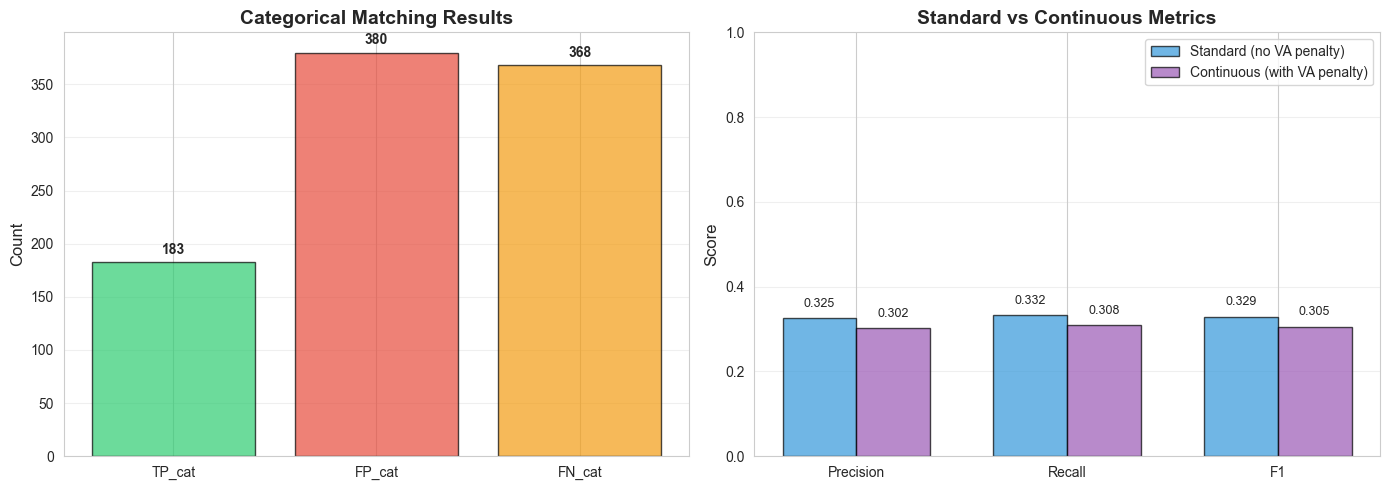

In [10]:
# Visualization 1: Confusion-style metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Categorical counts
categories = ['TP_cat', 'FP_cat', 'FN_cat']
values = [results['TP_cat'], results['FP_cat'], results['FN_cat']]
colors = ['#2ecc71', '#e74c3c', '#f39c12']

axes[0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Categorical Matching Results', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(values):
    axes[0].text(i, v + max(values)*0.02, str(v), ha='center', fontweight='bold')

# Plot 2: Metric comparison (Standard vs Continuous)
metrics = ['Precision', 'Recall', 'F1']
standard_vals = [results['standard_precision'], results['standard_recall'], results['standard_f1']]
continuous_vals = [results['cPrecision'], results['cRecall'], results['cF1']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1].bar(x - width/2, standard_vals, width, label='Standard (no VA penalty)', 
                     color='#3498db', alpha=0.7, edgecolor='black')
bars2 = axes[1].bar(x + width/2, continuous_vals, width, label='Continuous (with VA penalty)', 
                     color='#9b59b6', alpha=0.7, edgecolor='black')

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Standard vs Continuous Metrics', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

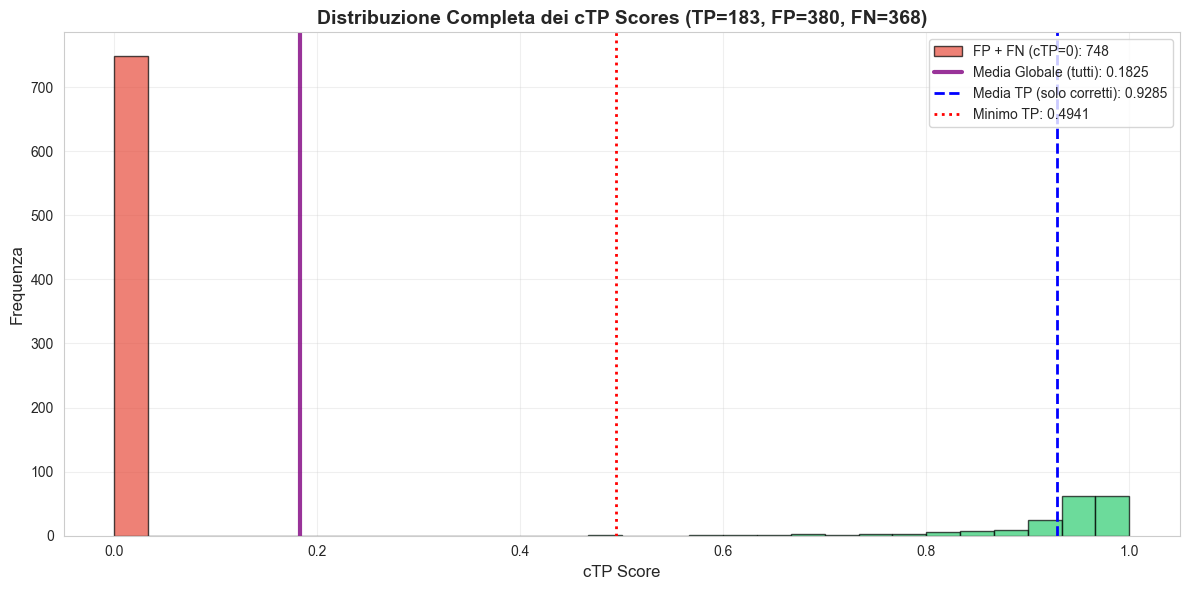


STATISTICHE cTP COMPLETE

📊 Composizione del grafico:
  • True Positives (TP):      183 con cTP ∈ [0.4941, 0.9956]
  • False Positives (FP):     380 con cTP = 0.0000 (no match categorico)
  • False Negatives (FN):     368 con cTP = 0.0000 (non predetti)
  • TOTALE quadruplet:        931

📈 Statistiche cTP (TUTTE le quadruplet, inclusi FP e FN):
  • Media cTP globale:       0.1825
  • Mediana cTP globale:     0.0000
  • Deviazione std globale:  0.3706

📈 Statistiche cTP (solo TP con cTP > 0):
  • Media cTP (solo TP):     0.9285
  • Mediana cTP (solo TP):   0.9522
  • Deviazione std (TP):     0.0775

📉 Percentuali:
  • % con cTP = 0:           80.34%
  • % con cTP > 0:           19.66%


In [11]:
# Visualization 2: Enhanced Distribution of cTP Scores (Including FP and FN as cTP=0)
if results['detailed_results'] and len(detailed_df) > 0:
    continuous_vals = detailed_df['cTP_score'].values
    
    # Aggiungi FP e FN con cTP = 0
    fp_count = results['FP_cat']
    fn_count = results['FN_cat']
    
    # Crea array completo: TP con i loro cTP + FP e FN con cTP=0
    all_ctp_values = np.concatenate([
        continuous_vals,  # 194 TP con cTP da 0.553 a 0.995
        np.zeros(fp_count),  # 452 FP con cTP = 0
        np.zeros(fn_count)   # 357 FN con cTP = 0
    ])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Istogramma con bins che iniziano da 0
    n, bins, patches = ax.hist(all_ctp_values, bins=30, color='#2ecc71', 
                                alpha=0.7, edgecolor='black', range=(0, 1))
    
    # Colora differentemente la barra a cTP=0 (che contiene FP+FN)
    patches[0].set_facecolor('#e74c3c')
    patches[0].set_label(f'FP + FN (cTP=0): {fp_count + fn_count}')
    
    # Media globale (tutti i valori inclusi FP e FN)
    mean_ctp_global = np.mean(all_ctp_values)
    
    # Media e minimo considerando SOLO i TP (escludendo gli zeri)
    mean_ctp_tp_only = np.mean(continuous_vals)
    min_ctp_tp_only = np.min(continuous_vals)
    
    # Linea media globale (include FP e FN con cTP=0)
    ax.axvline(mean_ctp_global, color='purple', linestyle='-', linewidth=3, 
               label=f'Media Globale (tutti): {mean_ctp_global:.4f}', alpha=0.8)
    
    # Linea media TP (solo True Positives)
    ax.axvline(mean_ctp_tp_only, color='blue', linestyle='--', linewidth=2, 
               label=f'Media TP (solo corretti): {mean_ctp_tp_only:.4f}')
    
    # Linea minimo TP
    ax.axvline(min_ctp_tp_only, color='red', linestyle=':', linewidth=2, 
               label=f'Minimo TP: {min_ctp_tp_only:.4f}')
    
    ax.set_xlabel('cTP Score', fontsize=12)
    ax.set_ylabel('Frequenza', fontsize=12)
    ax.set_title(f'Distribuzione Completa dei cTP Scores (TP={len(continuous_vals)}, FP={fp_count}, FN={fn_count})', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"STATISTICHE cTP COMPLETE")
    print(f"{'='*80}")
    print(f"\n📊 Composizione del grafico:")
    print(f"  • True Positives (TP):     {len(continuous_vals):>4} con cTP ∈ [{min_ctp_tp_only:.4f}, {np.max(continuous_vals):.4f}]")
    print(f"  • False Positives (FP):    {fp_count:>4} con cTP = 0.0000 (no match categorico)")
    print(f"  • False Negatives (FN):    {fn_count:>4} con cTP = 0.0000 (non predetti)")
    print(f"  • TOTALE quadruplet:       {len(all_ctp_values):>4}")
    print(f"\n📈 Statistiche cTP (TUTTE le quadruplet, inclusi FP e FN):")
    print(f"  • Media cTP globale:       {np.mean(all_ctp_values):.4f}")
    print(f"  • Mediana cTP globale:     {np.median(all_ctp_values):.4f}")
    print(f"  • Deviazione std globale:  {np.std(all_ctp_values):.4f}")
    print(f"\n📈 Statistiche cTP (solo TP con cTP > 0):")
    print(f"  • Media cTP (solo TP):     {mean_ctp_tp_only:.4f}")
    print(f"  • Mediana cTP (solo TP):   {np.median(continuous_vals):.4f}")
    print(f"  • Deviazione std (TP):     {np.std(continuous_vals):.4f}")
    print(f"\n📉 Percentuali:")
    print(f"  • % con cTP = 0:           {(fp_count + fn_count) / len(all_ctp_values) * 100:.2f}%")
    print(f"  • % con cTP > 0:           {len(continuous_vals) / len(all_ctp_values) * 100:.2f}%")
else:
    print("No data available for visualization.")


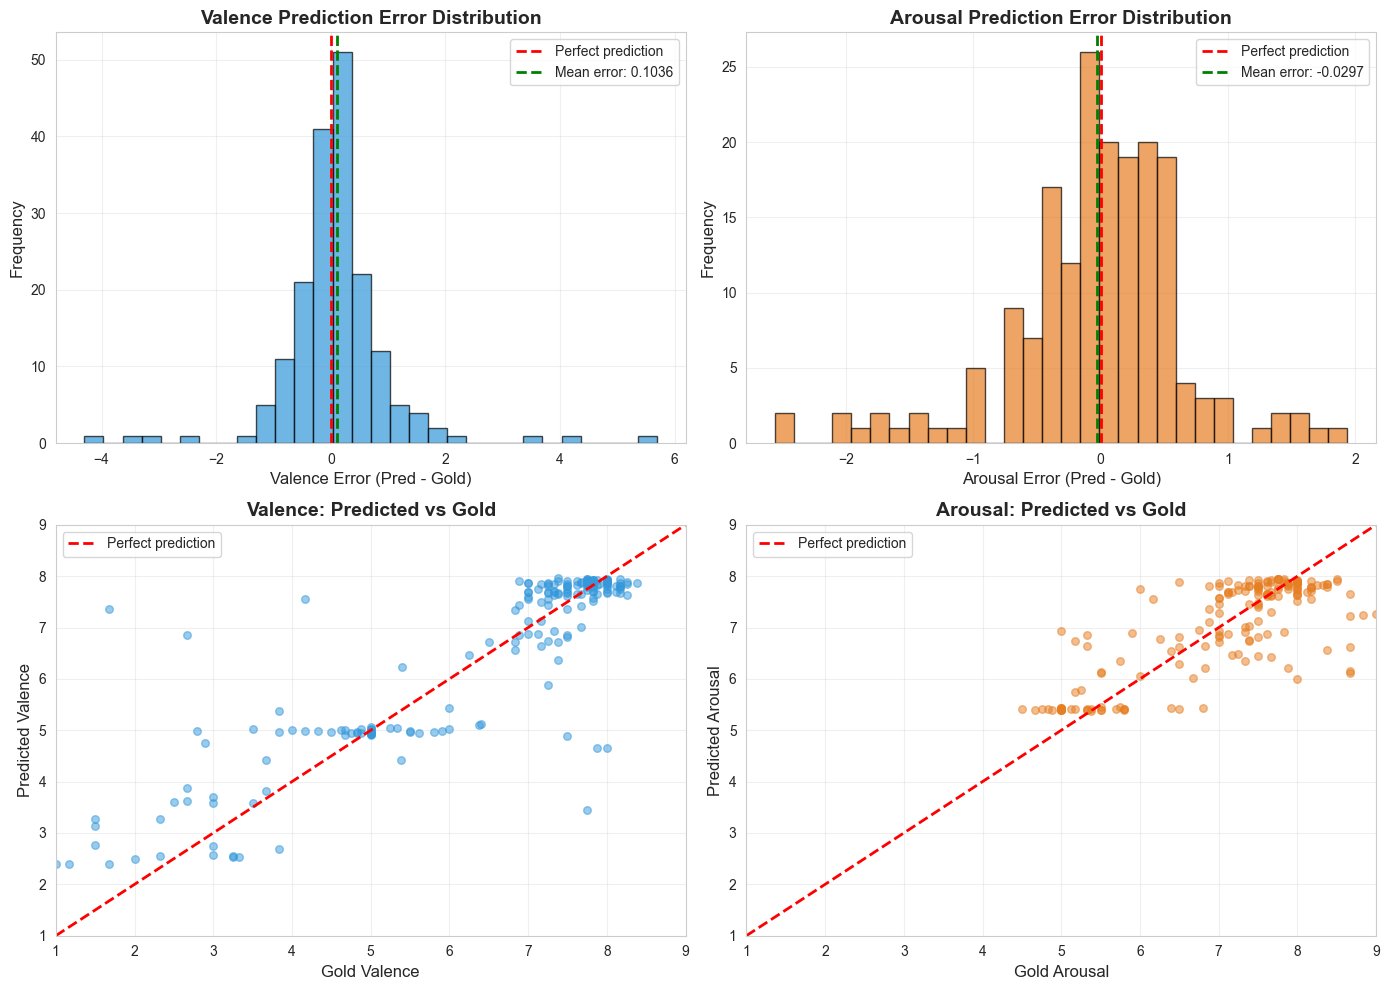


VALENCE & AROUSAL ERROR STATISTICS

Valence Error:
  Mean:   0.1036
  Median: 0.0800
  Std:    0.9669
  MAE:    0.5743

Arousal Error:
  Mean:   -0.0297
  Median: 0.0000
  Std:    0.6899
  MAE:    0.4913


In [12]:
# Visualization 3: Valence and Arousal Error Analysis
if results['detailed_results'] and len(detailed_df) > 0:
    # Extract V and A values
    v_errors = []
    a_errors = []
    
    for _, row in detailed_df.iterrows():
        gold_v, gold_a = parse_va(row['Gold_VA'])
        pred_v, pred_a = parse_va(row['Pred_VA'])
        v_errors.append(pred_v - gold_v)
        a_errors.append(pred_a - gold_a)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Valence Error Distribution
    axes[0, 0].hist(v_errors, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    axes[0, 0].axvline(np.mean(v_errors), color='green', linestyle='--', 
                       linewidth=2, label=f'Mean error: {np.mean(v_errors):.4f}')
    axes[0, 0].set_xlabel('Valence Error (Pred - Gold)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Valence Prediction Error Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Arousal Error Distribution
    axes[0, 1].hist(a_errors, bins=30, color='#e67e22', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    axes[0, 1].axvline(np.mean(a_errors), color='green', linestyle='--', 
                       linewidth=2, label=f'Mean error: {np.mean(a_errors):.4f}')
    axes[0, 1].set_xlabel('Arousal Error (Pred - Gold)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Arousal Prediction Error Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Plot 3: Valence Scatter
    gold_v_vals = [parse_va(row['Gold_VA'])[0] for _, row in detailed_df.iterrows()]
    pred_v_vals = [parse_va(row['Pred_VA'])[0] for _, row in detailed_df.iterrows()]
    
    axes[1, 0].scatter(gold_v_vals, pred_v_vals, alpha=0.5, color='#3498db', s=30)
    axes[1, 0].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
    axes[1, 0].set_xlabel('Gold Valence', fontsize=12)
    axes[1, 0].set_ylabel('Predicted Valence', fontsize=12)
    axes[1, 0].set_title('Valence: Predicted vs Gold', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_xlim(1, 9)
    axes[1, 0].set_ylim(1, 9)
    
    # Plot 4: Arousal Scatter
    gold_a_vals = [parse_va(row['Gold_VA'])[1] for _, row in detailed_df.iterrows()]
    pred_a_vals = [parse_va(row['Pred_VA'])[1] for _, row in detailed_df.iterrows()]
    
    axes[1, 1].scatter(gold_a_vals, pred_a_vals, alpha=0.5, color='#e67e22', s=30)
    axes[1, 1].plot([1, 9], [1, 9], 'r--', linewidth=2, label='Perfect prediction')
    axes[1, 1].set_xlabel('Gold Arousal', fontsize=12)
    axes[1, 1].set_ylabel('Predicted Arousal', fontsize=12)
    axes[1, 1].set_title('Arousal: Predicted vs Gold', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_xlim(1, 9)
    axes[1, 1].set_ylim(1, 9)
    
    plt.tight_layout()
    plt.show()
    
    # Print error statistics
    print("\n" + "="*80)
    print("VALENCE & AROUSAL ERROR STATISTICS")
    print("="*80)
    print(f"\nValence Error:")
    print(f"  Mean:   {np.mean(v_errors):.4f}")
    print(f"  Median: {np.median(v_errors):.4f}")
    print(f"  Std:    {np.std(v_errors):.4f}")
    print(f"  MAE:    {np.mean(np.abs(v_errors)):.4f}")
    
    print(f"\nArousal Error:")
    print(f"  Mean:   {np.mean(a_errors):.4f}")
    print(f"  Median: {np.median(a_errors):.4f}")
    print(f"  Std:    {np.std(a_errors):.4f}")
    print(f"  MAE:    {np.mean(np.abs(a_errors)):.4f}")
else:
    print("No data available for visualization.")

## 8. Category-wise Performance Analysis

Analyze performance across different aspect categories.


CATEGORY-WISE PERFORMANCE

Performance by Aspect Category:
                          Count  Mean_Dist  Std_Dist  Min_Dist  Max_Dist  Mean_cTP  Std_cTP
Category                                                                                   
restaurant#prices             3     0.3184    0.2482    0.0369    0.5059    0.6816   0.2482
food#quality                 82     0.0792    0.0812    0.0048    0.3695    0.9208   0.0812
restaurant#general           30     0.0719    0.0613    0.0115    0.2558    0.9281   0.0613
service#general              42     0.0556    0.0431    0.0101    0.1962    0.9444   0.0431
drinks#quality                1     0.0494       NaN    0.0494    0.0494    0.9506      NaN
ambience#general             16     0.0483    0.0448    0.0044    0.1771    0.9517   0.0448
drinks#style_options          4     0.0473    0.0402    0.0161    0.1038    0.9527   0.0402
restaurant#miscellaneous      1     0.0364       NaN    0.0364    0.0364    0.9636      NaN
food#prices         

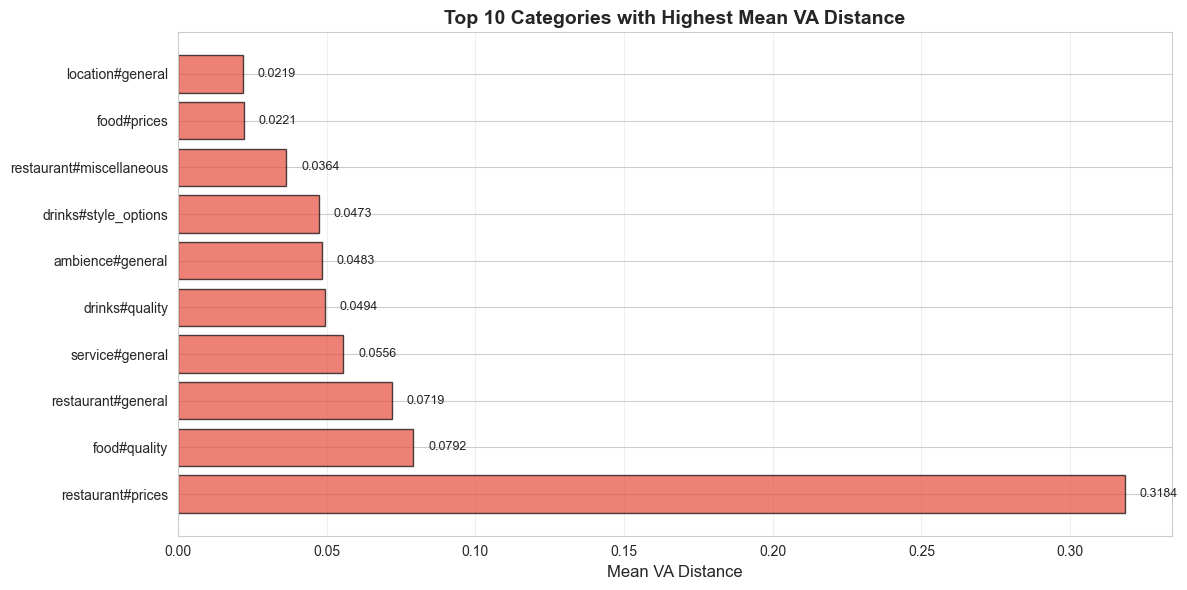

In [13]:
# Category-wise analysis
if results['detailed_results'] and len(detailed_df) > 0:
    # Group by category
    category_stats = detailed_df.groupby('Category').agg({
        'VA_distance': ['count', 'mean', 'std', 'min', 'max'],
        'cTP_score': ['mean', 'std']
    }).round(4)
    
    category_stats.columns = ['Count', 'Mean_Dist', 'Std_Dist', 'Min_Dist', 'Max_Dist', 
                              'Mean_cTP', 'Std_cTP']
    category_stats = category_stats.sort_values('Mean_Dist', ascending=False)
    
    print("\n" + "="*80)
    print("CATEGORY-WISE PERFORMANCE")
    print("="*80)
    print("\nPerformance by Aspect Category:")
    print(category_stats.to_string())
    
    # Visualize top categories
    if len(category_stats) > 0:
        top_n = min(10, len(category_stats))
        fig, ax = plt.subplots(figsize=(12, 6))
        
        categories = category_stats.head(top_n).index
        mean_dists = category_stats.head(top_n)['Mean_Dist']
        
        bars = ax.barh(range(len(categories)), mean_dists, color='#e74c3c', alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(categories)))
        ax.set_yticklabels(categories)
        ax.set_xlabel('Mean VA Distance', fontsize=12)
        ax.set_title(f'Top {top_n} Categories with Highest Mean VA Distance', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{width:.4f}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
else:
    print("No data available for category analysis.")

## 9. Export Results

Save the evaluation results to files for further analysis or submission.

In [14]:
# Export summary results to JSON
summary_results = {
    'task': 'Track A - Subtask 3 (DimASQP)',
    'gold_file': gold_file_path,
    'pred_file': pred_file_path,
    'metrics': {
        'TP_cat': results['TP_cat'],
        'cTP_total': round(results['cTP_total'], 4),
        'FP_cat': results['FP_cat'],
        'FN_cat': results['FN_cat'],
        'cPrecision': round(results['cPrecision'], 4),
        'cRecall': round(results['cRecall'], 4),
        'cF1': round(results['cF1'], 4),
        'standard_precision': round(results['standard_precision'], 4),
        'standard_recall': round(results['standard_recall'], 4),
        'standard_f1': round(results['standard_f1'], 4)
    },
    'warnings': {
        'invalid_va_predictions': results['invalid_va_count'],
        'duplicate_predictions': results['duplicate_pred_count']
    }
}

# Save to JSON file
output_file = 'evaluation_results_subtask3.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(summary_results, f, indent=2, ensure_ascii=False)

print(f"\nSummary results saved to: {output_file}")

# Export detailed results to CSV
if results['detailed_results'] and len(detailed_df) > 0:
    csv_file = 'detailed_evaluation_results_subtask3.csv'
    detailed_df.to_csv(csv_file, index=False, encoding='utf-8')
    print(f"Detailed results saved to: {csv_file}")
    print(f"  Total matched predictions: {len(detailed_df)}")

print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)


Summary results saved to: evaluation_results_subtask3.json
Detailed results saved to: detailed_evaluation_results_subtask3.csv
  Total matched predictions: 183

EVALUATION COMPLETE!


# 10. Metrica cTP Alternativa Basata su Embeddings Semantici

In questa sezione proponiamo una **metrica cTP alternativa** che utilizza **embeddings semantici** invece della distanza VA.

## Approccio Proposto

Per ogni quadruplet predetto correttamente a livello categorico (match esatto su A, C, O), calcoliamo:

1. **Embeddings** per Aspect, Category e Opinion (sia predetti che gold)
2. **Cosine Similarity** tra ciascuna coppia:
   - `sim_aspect = cosine_similarity(embed(Aspect_pred), embed(Aspect_gold))`
   - `sim_category = cosine_similarity(embed(Category_pred), embed(Category_gold))`
   - `sim_opinion = cosine_similarity(embed(Opinion_pred), embed(Opinion_gold))`

3. **Nuovo cTP**:
   $$cTP_{semantic} = \frac{sim_{aspect} + sim_{category} + sim_{opinion}}{3}$$

   Questo punteggio è compreso tra 0 e 1 (assumendo embeddings normalizzati).

4. **Metriche finali** (combinando cTP semantico e VA distance):
   
   Le formule mantengono la **penalità VA distance** come nelle formule originali, ma usano il **cTP semantico** come base:
   
   $$cRecall_{semantic} = \frac{\sum_{t \in P_{cat}} cTP_{semantic}^{(t)} - \sum_{t \in P_{cat}} \text{dist}(VA_p^{(t)}, VA_g^{(t)})}{TP_{cat} + FN_{cat}}$$
   
   $$cPrecision_{semantic} = \frac{\sum_{t \in P_{cat}} cTP_{semantic}^{(t)} - \sum_{t \in P_{cat}} \text{dist}(VA_p^{(t)}, VA_g^{(t)})}{TP_{cat} + FP_{cat}}$$
   
   $$cF1_{semantic} = \frac{2 \times cRecall_{semantic} \times cPrecision_{semantic}}{cRecall_{semantic} + cPrecision_{semantic}}$$
   
   Dove $\text{dist}(VA_p, VA_g) = \frac{\sqrt{(V_p - V_g)^2 + (A_p - A_g)^2}}{\sqrt{128}}$ come nella metrica originale.

In [16]:
# Install sentence-transformers for embeddings
%pip install sentence-transformers scikit-learn -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# Import additional libraries for embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Load a pre-trained sentence transformer model
# Using 'all-MiniLM-L6-v2' - fast and efficient for semantic similarity
print("Loading sentence transformer model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully!")
print(f"  Model: all-MiniLM-L6-v2")
print(f"  Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

c:\Users\marco\Desktop\Marco\Programmazione\C\EsPoli\Large Language Models for Software Engineering\DimABSA2026\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0131 13:27:31.742000 18380 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading sentence transformer model...
Model loaded successfully!
  Model: all-MiniLM-L6-v2
  Embedding dimension: 384


## 10.1 Funzioni per la Metrica Basata su Embeddings

In [16]:
def calculate_semantic_similarity(text1: str, text2: str, model: SentenceTransformer) -> float:
    """
    Calculate cosine similarity between two text strings using sentence embeddings.
    
    Args:
        text1: First text string
        text2: Second text string
        model: SentenceTransformer model
        
    Returns:
        Cosine similarity score in [0, 1] (or [-1, 1] theoretically, but typically [0, 1])
    """
    # Handle empty strings
    if not text1 or not text2:
        return 0.0
    
    # Generate embeddings
    emb1 = model.encode([text1], convert_to_numpy=True)
    emb2 = model.encode([text2], convert_to_numpy=True)
    
    # Calculate cosine similarity
    similarity = cosine_similarity(emb1, emb2)[0][0]
    
    # Normalize to [0, 1] range (in case of negative values)
    similarity = max(0.0, min(1.0, (similarity + 1) / 2))
    
    return float(similarity)


def calculate_ctp_semantic(pred_quad: Dict, gold_quad: Dict, model: SentenceTransformer) -> float:
    """
    Calculate semantic cTP score for a quadruplet pair.
    
    The score is the average of cosine similarities for Aspect, Category, and Opinion.
    
    Args:
        pred_quad: Predicted quadruplet (normalized)
        gold_quad: Gold quadruplet (normalized)
        model: SentenceTransformer model
        
    Returns:
        cTP_semantic score in [0, 1]
    """
    # Calculate similarity for each component
    sim_aspect = calculate_semantic_similarity(
        pred_quad['Aspect'], gold_quad['Aspect'], model
    )
    sim_category = calculate_semantic_similarity(
        pred_quad['Category'], gold_quad['Category'], model
    )
    sim_opinion = calculate_semantic_similarity(
        pred_quad['Opinion'], gold_quad['Opinion'], model
    )
    
    # Average of the three similarities
    ctp_score = (sim_aspect + sim_category + sim_opinion) / 3.0
    
    return ctp_score


print("✓ Semantic similarity functions defined successfully!")

✓ Semantic similarity functions defined successfully!


## 10.2 Funzione di Valutazione con Metrica Semantica

In [24]:
def evaluate_subtask3_semantic(
    gold_dict: Dict[str, List[Dict]],
    pred_dict: Dict[str, List[Dict]],
    model: SentenceTransformer,
    semantic_threshold: float = 0.85
) -> Dict:

    import numpy as np
    from scipy.optimize import linear_sum_assignment

    cTP_semantic_total = 0.0
    va_distance_total = 0.0
    TP_cat = 0
    FP_cat = 0
    FN_cat = 0

    invalid_va_count = 0
    detailed_results = []

    all_ids = set(pred_dict.keys())

    for entry_id in all_ids:
        gold_quads = gold_dict.get(entry_id, [])
        pred_quads = pred_dict.get(entry_id, [])

        n_gold = len(gold_quads)
        n_pred = len(pred_quads)

        # Trivial cases
        if n_gold == 0:
            FP_cat += n_pred
            continue
        if n_pred == 0:
            FN_cat += n_gold
            continue

        size = max(n_gold, n_pred)

        # Square cost matrix with dummy rows/cols
        cost_matrix = np.zeros((size, size))
        score_matrix = np.zeros((n_gold, n_pred))
        valid_pair = np.zeros((n_gold, n_pred), dtype=bool)

        # --- MATCHING BASED ONLY ON cTP ---
        for i, gold in enumerate(gold_quads):
            for j, pred in enumerate(pred_quads):
                cTP = calculate_ctp_semantic(pred, gold, model)

                if cTP <= semantic_threshold:
                    continue

                cost_matrix[i, j] = -cTP     # Hungarian maximizes cTP
                score_matrix[i, j] = cTP
                valid_pair[i, j] = True

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        matched_gold = set()
        matched_pred = set()

        for i, j in zip(row_ind, col_ind):
            # Ignore dummy matches
            if i >= n_gold or j >= n_pred:
                continue

            # Ignore invalid semantic pairs
            if not valid_pair[i, j]:
                continue

            matched_gold.add(i)
            matched_pred.add(j)

            TP_cat += 1
            cTP_semantic_total += score_matrix[i, j]

            # --- VA penalty applied ONLY AFTER matching ---
            if not is_valid_va(pred_quads[j]['VA']):
                invalid_va_count += 1
                va_dist = 1.0
            else:
                va_dist = calculate_va_distance(
                    pred_quads[j]['VA'],
                    gold_quads[i]['VA']
                )

            va_distance_total += va_dist

            detailed_results.append({
                'ID': entry_id,
                'Gold': gold_quads[i],
                'Pred': pred_quads[j],
                'cTP_semantic_score': score_matrix[i, j],
                'VA_distance': va_dist,
                'combined_score': score_matrix[i, j] - va_dist
            })

        FN_cat += n_gold - len(matched_gold)
        FP_cat += n_pred - len(matched_pred)

    numerator = cTP_semantic_total - va_distance_total

    cPrecision_semantic = numerator / (TP_cat + FP_cat) if (TP_cat + FP_cat) > 0 else 0.0
    cRecall_semantic = numerator / (TP_cat + FN_cat) if (TP_cat + FN_cat) > 0 else 0.0
    cF1_semantic = (
        2 * cPrecision_semantic * cRecall_semantic /
        (cPrecision_semantic + cRecall_semantic)
        if (cPrecision_semantic + cRecall_semantic) > 0 else 0.0
    )

    standard_precision = TP_cat / (TP_cat + FP_cat) if (TP_cat + FP_cat) > 0 else 0.0
    standard_recall = TP_cat / (TP_cat + FN_cat) if (TP_cat + FN_cat) > 0 else 0.0
    standard_f1 = (
        2 * standard_precision * standard_recall /
        (standard_precision + standard_recall)
        if (standard_precision + standard_recall) > 0 else 0.0
    )

    return {
        'TP_cat': TP_cat,
        'FP_cat': FP_cat,
        'FN_cat': FN_cat,
        'cTP_semantic_total': cTP_semantic_total,
        'va_distance_total': va_distance_total,
        'combined_score': numerator,
        'cPrecision_semantic': cPrecision_semantic,
        'cRecall_semantic': cRecall_semantic,
        'cF1_semantic': cF1_semantic,
        'standard_precision': standard_precision,
        'standard_recall': standard_recall,
        'standard_f1': standard_f1,
        'invalid_va_count': invalid_va_count,
        'semantic_threshold': semantic_threshold,
        'detailed_results': detailed_results
    }


print("✓ Semantic evaluation function defined successfully!")

✓ Semantic evaluation function defined successfully!


## 10.3 Esecuzione della Valutazione con Metrica Semantica

In [25]:
# Run the semantic evaluation
print("Running semantic evaluation (this may take a few moments)...\n")
results_semantic = evaluate_subtask3_semantic(gold_dict, pred_dict, embedding_model, 0.9)

# Display results
print("="*80)
print("EVALUATION RESULTS - Metrica cTP Semantica + VA Distance Penalty")
print("="*80)
print()

print("📊 CATEGORICAL MATCHING (Aspect, Category, Opinion):")
print(f"   True Positives (TP_cat):  {results_semantic['TP_cat']}")
print(f"   False Positives (FP_cat): {results_semantic['FP_cat']}")
print(f"   False Negatives (FN_cat): {results_semantic['FN_cat']}")
print()

print("📈 SEMANTIC + VA DISTANCE COMPONENTS:")
print(f"   Σ Semantic cTP:           {results_semantic['cTP_semantic_total']:.4f}")
print(f"   Σ VA Distance (penalty):  {results_semantic['va_distance_total']:.4f}")
print(f"   Combined Score:           {results_semantic['combined_score']:.4f}")
print()

print("📈 FINAL METRICS (cTP_semantic - VA_distance):")
print(f"   Continuous Precision:     {results_semantic['cPrecision_semantic']:.4f}")
print(f"   Continuous Recall:        {results_semantic['cRecall_semantic']:.4f}")
print(f"   Continuous F1 (cF1):      {results_semantic['cF1_semantic']:.4f}")
print()

print("📉 STANDARD METRICS (without any penalty):")
print(f"   Standard Precision:       {results_semantic['standard_precision']:.4f}")
print(f"   Standard Recall:          {results_semantic['standard_recall']:.4f}")
print(f"   Standard F1:              {results_semantic['standard_f1']:.4f}")
print()

if results_semantic['invalid_va_count'] > 0:
    print(f"⚠  Warning: {results_semantic['invalid_va_count']} predictions with invalid VA values")

print()
print("="*80)
print(f"🎯 FINAL SCORE (cF1): {results_semantic['cF1_semantic']:.4f}")
print("="*80)

Running semantic evaluation (this may take a few moments)...

EVALUATION RESULTS - Metrica cTP Semantica + VA Distance Penalty

📊 CATEGORICAL MATCHING (Aspect, Category, Opinion):
   True Positives (TP_cat):  288
   False Positives (FP_cat): 275
   False Negatives (FN_cat): 263

📈 SEMANTIC + VA DISTANCE COMPONENTS:
   Σ Semantic cTP:           282.3153
   Σ VA Distance (penalty):  20.8551
   Combined Score:           261.4603

📈 FINAL METRICS (cTP_semantic - VA_distance):
   Continuous Precision:     0.4644
   Continuous Recall:        0.4745
   Continuous F1 (cF1):      0.4694

📉 STANDARD METRICS (without any penalty):
   Standard Precision:       0.5115
   Standard Recall:          0.5227
   Standard F1:              0.5171


🎯 FINAL SCORE (cF1): 0.4694


## 10.4 Confronto tra Metrica VA e Metrica Semantica

In [26]:
# Compare the two approaches
print("="*80)
print("CONFRONTO: Metrica VA vs Metrica Semantica")
print("="*80)
print()

# Create comparison table
comparison_data = {
    'Metrica': ['VA-based', 'Semantic-based', 'Difference'],
    'cPrecision': [
        results['cPrecision'], 
        results_semantic['cPrecision_semantic'],
        results_semantic['cPrecision_semantic'] - results['cPrecision']
    ],
    'cRecall': [
        results['cRecall'], 
        results_semantic['cRecall_semantic'],
        results_semantic['cRecall_semantic'] - results['cRecall']
    ],
    'cF1': [
        results['cF1'], 
        results_semantic['cF1_semantic'],
        results_semantic['cF1_semantic'] - results['cF1']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print()

# Calculate percentage improvement
if results['cF1'] > 0:
    improvement_pct = ((results_semantic['cF1_semantic'] - results['cF1']) / results['cF1']) * 100
    print(f"Variazione percentuale cF1: {improvement_pct:+.2f}%")
print()

print("="*80)
print("OSSERVAZIONI:")
print("="*80)
if results_semantic['cF1_semantic'] > results['cF1']:
    print("✓ La metrica semantica produce un punteggio cF1 PIÙ ALTO")
    print("  → Gli embeddings sembrano catturare meglio la similarità semantica")
elif results_semantic['cF1_semantic'] < results['cF1']:
    print("⚠ La metrica semantica produce un punteggio cF1 PIÙ BASSO")
    print("  → La distanza VA potrebbe essere più appropriata per questo task")
else:
    print("→ Le due metriche producono risultati identici")

print(f"\nDifferenza assoluta cF1: {abs(results_semantic['cF1_semantic'] - results['cF1']):.4f}")

CONFRONTO: Metrica VA vs Metrica Semantica

       Metrica  cPrecision  cRecall      cF1
      VA-based    0.301814 0.308387 0.305065
Semantic-based    0.464405 0.474520 0.469408
    Difference    0.162591 0.166132 0.164343

Variazione percentuale cF1: +53.87%

OSSERVAZIONI:
✓ La metrica semantica produce un punteggio cF1 PIÙ ALTO
  → Gli embeddings sembrano catturare meglio la similarità semantica

Differenza assoluta cF1: 0.1643


## 10.5 Analisi Dettagliata dei Punteggi Semantici

In [27]:
# Analyze semantic cTP scores
if results_semantic['detailed_results']:
    detailed_semantic_df = pd.DataFrame([{
        'ID': r['ID'],
        'Aspect': r['Gold']['Aspect'],
        'Category': r['Gold']['Category'],
        'Opinion': r['Gold']['Opinion'],
        'Gold_VA': r['Gold']['VA'],
        'Pred_VA': r['Pred']['VA'],
        'cTP_semantic': r['cTP_semantic_score'],
        'VA_distance': r['VA_distance'],
        'combined_score': r['combined_score']
    } for r in results_semantic['detailed_results']])
    
    print("="*80)
    print("STATISTICHE PUNTEGGI - SEMANTICI + VA DISTANCE")
    print("="*80)
    print(f"\nTotal matched predictions: {len(detailed_semantic_df)}")
    
    print(f"\ncTP Semantic Statistics:")
    print(detailed_semantic_df['cTP_semantic'].describe())
    
    print(f"\nVA Distance Statistics:")
    print(detailed_semantic_df['VA_distance'].describe())
    
    print(f"\nCombined Score (cTP_semantic - VA_distance) Statistics:")
    print(detailed_semantic_df['combined_score'].describe())
    
    # Show best and worst predictions based on combined score
    print("\n" + "-"*80)
    print("🏆 TOP 5 MIGLIORI PREDIZIONI (highest combined score):")
    print("-"*80)
    best_combined = detailed_semantic_df.nlargest(5, 'combined_score')
    for idx, row in best_combined.iterrows():
        print(f"\nID: {row['ID']}")
        print(f"   Aspect: '{row['Aspect']}' | Category: {row['Category']} | Opinion: '{row['Opinion']}'")
        print(f"   Gold VA: {row['Gold_VA']} | Pred VA: {row['Pred_VA']}")
        print(f"   cTP Semantic: {row['cTP_semantic']:.4f} | VA Distance: {row['VA_distance']:.4f}")
        print(f"   Combined Score: {row['combined_score']:.4f}")
    
    print("\n" + "-"*80)
    print("⚠️  TOP 5 PEGGIORI PREDIZIONI (lowest combined score):")
    print("-"*80)
    worst_combined = detailed_semantic_df.nsmallest(5, 'combined_score')
    for idx, row in worst_combined.iterrows():
        print(f"\nID: {row['ID']}")
        print(f"   Aspect: '{row['Aspect']}' | Category: {row['Category']} | Opinion: '{row['Opinion']}'")
        print(f"   Gold VA: {row['Gold_VA']} | Pred VA: {row['Pred_VA']}")
        print(f"   cTP Semantic: {row['cTP_semantic']:.4f} | VA Distance: {row['VA_distance']:.4f}")
        print(f"   Combined Score: {row['combined_score']:.4f}")
else:
    print("\n⚠ No matched predictions found for detailed analysis.")

STATISTICHE PUNTEGGI - SEMANTICI + VA DISTANCE

Total matched predictions: 288

cTP Semantic Statistics:
count    288.000000
mean       0.980262
std        0.029693
min        0.901133
25%        0.958100
50%        1.000000
75%        1.000000
max        1.000000
Name: cTP_semantic, dtype: float64

VA Distance Statistics:
count    288.000000
mean       0.072413
std        0.074120
min        0.004419
25%        0.025962
50%        0.050380
75%        0.087415
max        0.505907
Name: VA_distance, dtype: float64

Combined Score (cTP_semantic - VA_distance) Statistics:
count    288.000000
mean       0.907848
std        0.078575
min        0.494093
25%        0.871315
50%        0.926958
75%        0.963963
max        0.995581
Name: combined_score, dtype: float64

--------------------------------------------------------------------------------
🏆 TOP 5 MIGLIORI PREDIZIONI (highest combined score):
--------------------------------------------------------------------------------

ID: rest1

## 10.6 Visualizzazioni Comparative

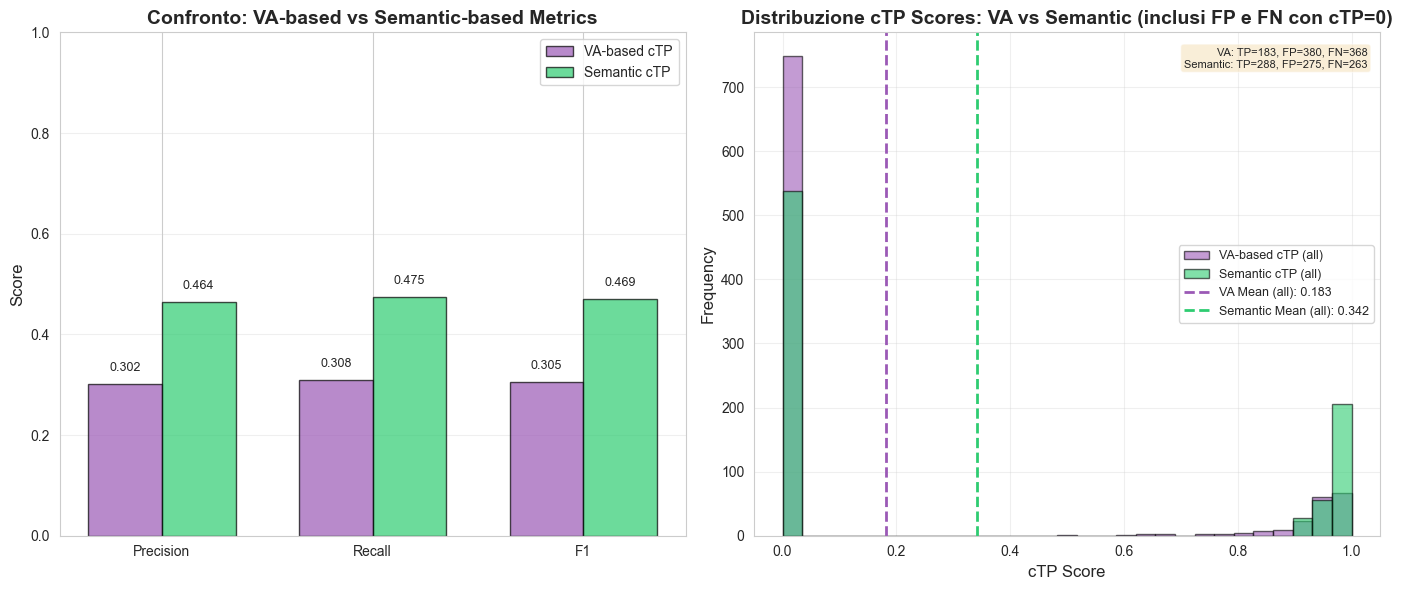

In [28]:
# Visualization: Compare VA-based vs Semantic-based metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Side-by-side comparison of cF1 metrics
metrics = ['Precision', 'Recall', 'F1']
va_vals = [results['cPrecision'], results['cRecall'], results['cF1']]
semantic_vals = [results_semantic['cPrecision_semantic'], 
                 results_semantic['cRecall_semantic'], 
                 results_semantic['cF1_semantic']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, va_vals, width, label='VA-based cTP', 
                     color='#9b59b6', alpha=0.7, edgecolor='black')
bars2 = axes[0].bar(x + width/2, semantic_vals, width, label='Semantic cTP', 
                     color='#2ecc71', alpha=0.7, edgecolor='black')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Confronto: VA-based vs Semantic-based Metrics', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim(0, 1.0)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Distribution comparison of cTP scores
if results['detailed_results'] and results_semantic['detailed_results']:
    # VA-based: include TP with their scores + FP and FN with cTP=0
    va_ctp_scores = [r['cTP_score'] for r in results['detailed_results']]
    va_fp_count = results['FP_cat']
    va_fn_count = results['FN_cat']
    all_va_ctp_values = np.concatenate([
        va_ctp_scores,  # TP with their cTP scores
        np.zeros(va_fp_count),  # FP with cTP = 0
        np.zeros(va_fn_count)   # FN with cTP = 0
    ])
    
    # Semantic-based: include TP with their scores + FP and FN with cTP=0
    semantic_ctp_scores = [r['cTP_semantic_score'] for r in results_semantic['detailed_results']]
    semantic_fp_count = results_semantic['FP_cat']
    semantic_fn_count = results_semantic['FN_cat']
    all_semantic_ctp_values = np.concatenate([
        semantic_ctp_scores,  # TP with their cTP scores
        np.zeros(semantic_fp_count),  # FP with cTP = 0
        np.zeros(semantic_fn_count)   # FN with cTP = 0
    ])
    
    # Create bins for histogram
    bins = np.linspace(0, 1, 30)
    
    axes[1].hist(all_va_ctp_values, bins=bins, alpha=0.6, label='VA-based cTP (all)', 
                 color='#9b59b6', edgecolor='black')
    axes[1].hist(all_semantic_ctp_values, bins=bins, alpha=0.6, label='Semantic cTP (all)', 
                 color='#2ecc71', edgecolor='black')
    
    # Add mean lines (considering ALL values including FP and FN)
    axes[1].axvline(np.mean(all_va_ctp_values), color='#9b59b6', linestyle='--', 
                    linewidth=2, label=f'VA Mean (all): {np.mean(all_va_ctp_values):.3f}')
    axes[1].axvline(np.mean(all_semantic_ctp_values), color='#2ecc71', linestyle='--', 
                    linewidth=2, label=f'Semantic Mean (all): {np.mean(all_semantic_ctp_values):.3f}')
    
    axes[1].set_xlabel('cTP Score', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Distribuzione cTP Scores: VA vs Semantic (inclusi FP e FN con cTP=0)', 
                      fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(alpha=0.3)
    
    # Add annotation with statistics
    textstr = (f'VA: TP={len(va_ctp_scores)}, FP={va_fp_count}, FN={va_fn_count}\n'
               f'Semantic: TP={len(semantic_ctp_scores)}, FP={semantic_fp_count}, FN={semantic_fn_count}')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[1].text(0.98, 0.97, textstr, transform=axes[1].transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

## 10.7 Esportazione Risultati Metrica Semantica

In [29]:
# Export semantic evaluation results
summary_semantic = {
    'task': 'Track A - Subtask 3 (DimASQP) - Semantic cTP Metric',
    'gold_file': gold_file_path,
    'pred_file': pred_file_path,
    'embedding_model': 'all-MiniLM-L6-v2',
    'metrics': {
        'TP_cat': results_semantic['TP_cat'],
        'cTP_semantic_total': round(results_semantic['cTP_semantic_total'], 4),
        'FP_cat': results_semantic['FP_cat'],
        'FN_cat': results_semantic['FN_cat'],
        'cPrecision_semantic': round(results_semantic['cPrecision_semantic'], 4),
        'cRecall_semantic': round(results_semantic['cRecall_semantic'], 4),
        'cF1_semantic': round(results_semantic['cF1_semantic'], 4),
        'standard_precision': round(results_semantic['standard_precision'], 4),
        'standard_recall': round(results_semantic['standard_recall'], 4),
        'standard_f1': round(results_semantic['standard_f1'], 4)
    },
    'comparison_with_va': {
        'va_cF1': round(results['cF1'], 4),
        'semantic_cF1': round(results_semantic['cF1_semantic'], 4),
        'difference': round(results_semantic['cF1_semantic'] - results['cF1'], 4),
        'improvement_pct': round(((results_semantic['cF1_semantic'] - results['cF1']) / results['cF1'] * 100) 
                                 if results['cF1'] > 0 else 0, 2)
    },
}

# Save to JSON file
output_file_semantic = 'evaluation_results_subtask3_semantic.json'
with open(output_file_semantic, 'w', encoding='utf-8') as f:
    json.dump(summary_semantic, f, indent=2, ensure_ascii=False)

print(f"✓ Semantic evaluation results saved to: {output_file_semantic}")

# Export detailed semantic results to CSV
if results_semantic['detailed_results']:
    csv_file_semantic = 'detailed_evaluation_results_subtask3_semantic.csv'
    detailed_semantic_df.to_csv(csv_file_semantic, index=False, encoding='utf-8')
    print(f"✓ Detailed semantic results saved to: {csv_file_semantic}")
    print(f"  Total matched predictions: {len(detailed_semantic_df)}")

print("\n" + "="*80)
print("VALUTAZIONE CON METRICA SEMANTICA COMPLETATA!")
print("="*80)
print(f"\n📊 RIEPILOGO FINALE:")
print(f"   • VA-based cF1:       {results['cF1']:.4f}")
print(f"   • Semantic cF1:       {results_semantic['cF1_semantic']:.4f}")
print(f"   • Differenza:         {results_semantic['cF1_semantic'] - results['cF1']:+.4f}")
print("="*80)

✓ Semantic evaluation results saved to: evaluation_results_subtask3_semantic.json
✓ Detailed semantic results saved to: detailed_evaluation_results_subtask3_semantic.csv
  Total matched predictions: 288

VALUTAZIONE CON METRICA SEMANTICA COMPLETATA!

📊 RIEPILOGO FINALE:
   • VA-based cF1:       0.3051
   • Semantic cF1:       0.4694
   • Differenza:         +0.1643
